In [1]:
%matplotlib inline
import tensorflow as tf
from tfutils import base, data, model, optimizer, utils
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('assignment1')

from dldata.metrics.utils import compute_metric_base

Can't import separate mcc package
Can't import asgd.
Can't import scikits stuff


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# test images
n_images = 100
resolution = 227
channel = 3
images = tf.Variable(tf.truncated_normal([n_images,resolution,resolution,channel]))
labels = np.random.permutation(range(n_images))
inputs = {'images': images,
         'labels': labels}
# Example for getting a variable
"""
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
images_array = inputs['images'].eval(sess)
sess.close()
"""

"\nsess = tf.Session()\ninit = tf.global_variables_initializer()\nsess.run(init)\nimages_array = inputs['images'].eval(sess)\nsess.close()\n"

In [ ]:
# plt.imshow(images_array[0,::]) # example image plot

## Loading Database

In [3]:
import pymongo as pm
port = 24444
dbname = 'assignment1'
collection = 'alexnet.files'
exp_id = '1st_experiment'

connection = pm.MongoClient(port=port)
connection.database_names()
db = connection[dbname]
col1 = db[collection]
exp_out = list(col1.find({'exp_id': exp_id}))
validation_results = list(col1.find({'validation_results' : {'$exists' : True}}))

In [4]:
training_events = list(col1.find({'exp_id': exp_id, 'validation_results' : {'$exists' : False}}))
train_results = [i for sublist in training_events for i in sublist['train_results']]

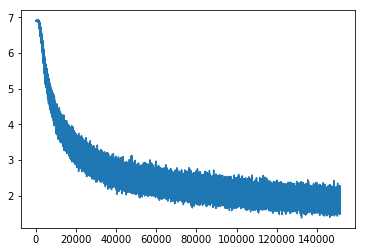

In [5]:
# plotting loss
plt.plot([i['loss'] for i in train_results])

## TFUtils

In [ ]:
from dataprovider import ImageNetDataProvider

## Testing AlexNet

In [ ]:
from models import lenet_model
model_layers, _ = lenet_model(inputs)
out = model_layers['pred']
out

In [ ]:
model_layers

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
predictions = sess.run(out)
sess.close()
predictions.shape

In [ ]:
# in_top_k
pred = np.array([[.2,.5,.3],[.7,.1,.1]])
targets = np.array([1,1])
func = tf.nn.in_top_k(pred,targets,1)

sess = tf.Session()
sess.run(func)
sess.close()

## Testing gabors

In [6]:
%matplotlib inline
from skimage.filters import gabor_kernel
from skimage import io
from matplotlib import pyplot as plt  
import math

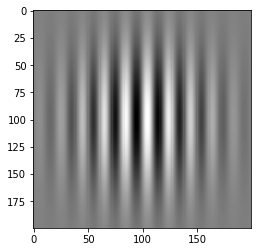

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

size = np.linspace(-np.pi,np.pi,200)
xgrid, ygrid = np.meshgrid(size, size)

gaussian = np.exp(-(xgrid/2)**2-(ygrid/2)**2) 
sine = np.sin(xgrid*10)
gabor = sine * gaussian
plt.imshow(gabor,cm.gray) 
plt.show()

In [ ]:
np.arange(0,2*math.pi,0.1)

In [ ]:
import pymongo as pm
connection = pm.MongoClient(port=24444)
connection.database_names()
db = connection['imagenet']
col1 = db['alexnet']
exp_out = list(col1.find({'exp_id': 'experiment_1'}))
exp_out

In [ ]:
exp_out